In [54]:
import os
from PIL import Image

In [55]:
first_class_train =  'data/1class_train/'
second_class_train =  'data/2class_train/'
third_class_train =  'data/3class_train/'

first_class_test = 'data/1class_test/'
second_class_test = 'data/2class_test/'
third_class_test = 'data/3class_test/'

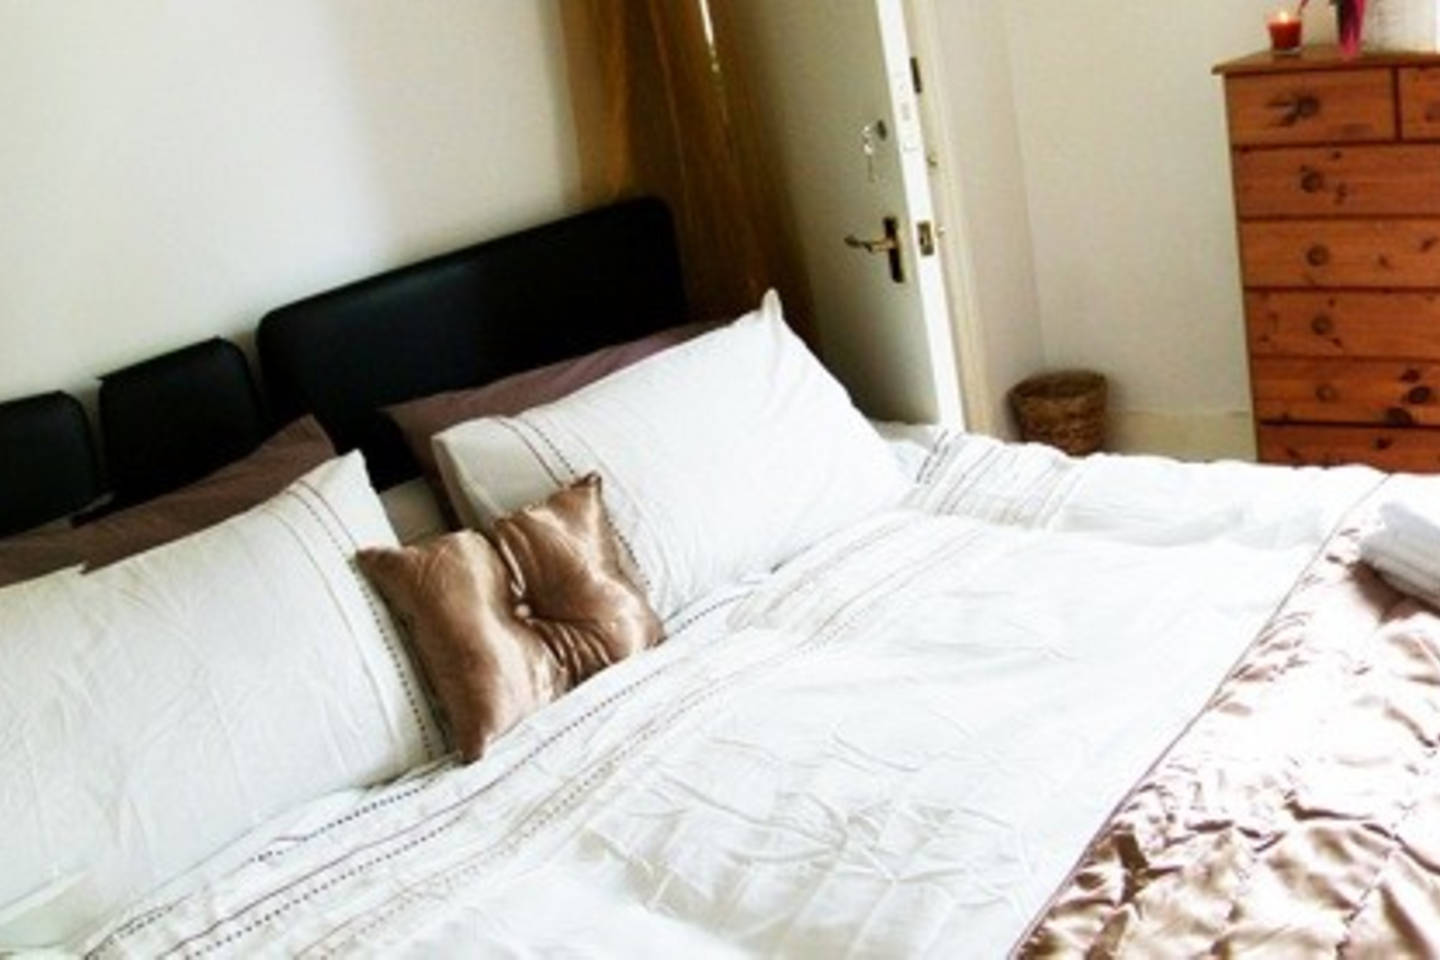

In [56]:
basewidth = 300
img = Image.open('./data/1class_test/1161502.jpg')
img


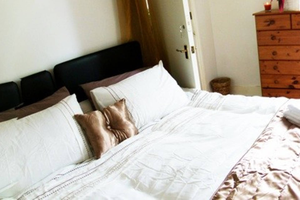

In [57]:
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
#img.save('resized.jpg') 
img

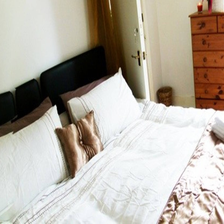

In [58]:
img_test = Image.open('./data/1class_test/1161502.jpg')
img_test.resize((224,224), Image.ANTIALIAS)



In [59]:
new_size = 224

def getImages_wo_resize(path):
    names = os.listdir(path)
    img_arr = []
    for name in names:
        p = path + name
        img = Image.open(p)
        img_arr.append(img)
    return img_arr

def getImages(path):
    names = os.listdir(path)
    img_arr = []
    for name in names:
        p = path + name
        img = Image.open(p)
        print(p)
        img_arr.append(resize(img, new_size))
    return img_arr


def resize(img, size):
    #wpercent = basewidth / img.size[0]
    #hsize = int((float(img.size[1]) * float(wpercent)))
    #return img.resize((basewidth,hsize), Image.ANTIALIAS)
    return img.resize((size, size), Image.ANTIALIAS)

In [60]:
first_class_train_img = getImages(first_class_train)
second_class_train_img = getImages(second_class_train)
third_class_train_img = getImages(third_class_train)

first_class_test_img = getImages(first_class_test)
second_class_test_img = getImages(second_class_test)
third_class_test_img = getImages(third_class_test)

data/1class_train/10002555.jpg
data/1class_train/10005675.jpg
data/1class_train/10006571.jpg
data/1class_train/10006730.jpg
data/1class_train/10007372.jpg
data/1class_train/10007434.jpg
data/1class_train/10007608.jpg
data/1class_train/10008307.jpg
data/1class_train/10009627.jpg
data/1class_train/10012028.jpg
data/1class_train/10012793.jpg
data/1class_train/10014542.jpg
data/1class_train/10016688.jpg
data/1class_train/10020549.jpg
data/1class_train/1002115.jpg
data/1class_train/10026111.jpg
data/1class_train/10026158.jpg
data/1class_train/1002787.jpg
data/1class_train/10027923.jpg
data/1class_train/10027962.jpg
data/1class_train/10030621.jpg
data/1class_train/10030850.jpg
data/1class_train/10031024.jpg
data/1class_train/10031152.jpg
data/1class_train/10031252.jpg
data/1class_train/10031256.jpg
data/1class_train/10032320.jpg
data/1class_train/100326.jpg
data/1class_train/100326_.jpg
data/1class_train/10032762.jpg
data/1class_train/10033177.jpg
data/1class_train/10033375.jpg
data/1class_t

In [61]:
len(first_class_train_img)

1000

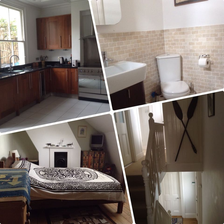

In [62]:
second_class_test_img[9]

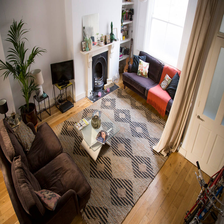

In [63]:
first_class_test_img[1]

In [64]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils

img_rows, img_cols = 224, 224 
first_class_train_img

[<PIL.Image.Image image mode=RGB size=224x224 at 0x10967FDA0>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x10967FD68>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x10967FEB8>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x10967FF28>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x10967FFD0>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x10967FF98>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1092B90B8>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1092B9128>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1092B9198>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1092B9208>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1092B9278>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1092B92E8>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1092B9358>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1092B9400>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1092B9080>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x1092

In [70]:
# make (X_train, y_train), (X_test, y_test)


import numpy as np

X_train = np.array([first_class_train_img, second_class_train_img, third_class_train_img], dtype='int')
y_train = np.array([np.repeat(1, len(first_class_train_img)),
                    np.repeat(2, len(second_class_train_img)),
                    np.repeat(3, len(second_class_train_img))])

X_test = np.array([first_class_test_img, second_class_test_img, third_class_test_img])
y_test = np.array([np.repeat(1, len(first_class_test_img)),
                    np.repeat(2, len(second_class_test_img)),
                    np.repeat(3, len(second_class_test_img))])

                              
len_train = len(first_class_train_img) + len(second_class_train_img) + len(third_class_train_img)
print(len(first_class_train_img))
print(X_train.shape)
print(len_train)
X_train  = X_train.reshape(len_train)
y_train = y_train.reshape(len_train)


len_test = len(first_class_test_img) + len(second_class_test_img) + len(third_class_test_img)
X_test = X_test.reshape(len_test)
y_test = y_test.reshape(len_test)



TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'

In [ ]:
#theano

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
input_shape = (1, img_rows, img_cols)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, 3)
Y_test = np_utils.to_categorical(y_test, 3)

In [ ]:

model = Sequential()
model.add(Convolution2D(nb_filter, 3, 3, input_shape=(img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filter, 1, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [ ]:
nb_epoch = 4

res = model.fit(X_train, Y_train, batch_size=128, nb_epoch=nb_epoch, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

x = range(nb_epoch)

plt.plot(x, res.history['acc'], label="train acc")
plt.plot(x, res.history['val_acc'], label="val acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(x, res.history['loss'], label="train loss")
plt.plot(x, res.history['val_loss'], label="val loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))